We see if the bic criterion finds flags in climate bench datasets. The flag type it finds is just the "Siefel"-type. E.g., $(1,2,3,\dots,k;n)$

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pickle as pkl

import sys
sys.path.append('/Users/natemankovich/Documents/PostDoc/DMDc4Climate/')
from utils import *

from PSA_utils import *

import os

In [2]:
n_pcs = 5



for scenario in [585,370,245,126]:

    xr_train_emissions = load_emissions_dataset('/Users/natemankovich/Documents/PostDoc/DMDc4Climate/data/train_val/inputs_historical.nc')
    xr_test_emissions = load_emissions_dataset(f'/Users/natemankovich/Documents/PostDoc/DMDc4Climate/data/train_val/inputs_ssp{scenario}.nc')
    times, emissions_data = extract_forcing_agents(xr_train_emissions, xr_test_emissions)

    xr_train_clim = xr.open_dataset('/Users/natemankovich/Documents/PostDoc/DMDc4Climate/data/train_val/outputs_historical.nc').mean(dim='member')
    xr_test_clim = xr.open_dataset(f'/Users/natemankovich/Documents/PostDoc/DMDc4Climate/data/train_val/outputs_ssp{scenario}.nc').mean(dim='member')

    tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas.values
    ntime, nlat, nlong = tas_all.shape
    tas_data = tas_all.reshape(ntime, -1)

    my_pca = PCA()   #(svd_rank=5) 
    my_pca.fit(tas_data)
    evrs = my_pca.explained_variance_ratio_
    weights  = my_pca.components_
    eigval = my_pca.explained_variance_

    X = tas_data.T
    n,p = X.shape

    candidate_models = [[1,1,1,1,1,p-n_pcs],
        [1,1,1,2,p-n_pcs],[1,1,2,1,p-n_pcs],[1,2,1,1,p-n_pcs],[2,1,1,1,p-n_pcs],
        [3,1,1,p-n_pcs],[2,2,1,p-n_pcs],[1,3,1,p-n_pcs],[2,1,2,p-n_pcs],[1,2,2,p-n_pcs],[1,1,3,p-n_pcs],
        [4,1,p-n_pcs],[3,2,p-n_pcs],[2,3,p-n_pcs],[1,4,p-n_pcs],
        [5,p-n_pcs]]

    model_best = None; crit_best = np.inf
    for model in candidate_models:
        crit_model = bic(model, eigval, n)
        if crit_model < crit_best:
                model_best = model
                crit_best = crit_model

    print(model_best)

[1, 1, 1, 1, 1, 246]
[1, 1, 1, 1, 1, 246]
[1, 1, 1, 1, 1, 246]
[1, 1, 1, 1, 1, 246]


In [3]:

true_forced_response = xr.open_dataset('/Users/natemankovich/Documents/PostDoc/ForceSMIP/data/CESM2_ensemble_average_tas.nc')


climatology_fr = true_forced_response['__xarray_dataarray_variable__'].groupby('time.month').mean(dim='time')
anomalies_fr = true_forced_response['__xarray_dataarray_variable__'].groupby('time.month') - climatology_fr

[t, nlat, nlon] = np.array(anomalies_fr).shape

data_path = '/Users/natemankovich/Documents/PostDoc/ForceSMIP/data'
models = ['CESM2']#['MPI-ESM1-2-LR', 'MIROC6', 'MIROC-ES2L', 'CanESM5', 'CESM2']
var = 'tas'

ensemble = {}
dmd_corrs_means = []
dmd_corrs_stds = []
dmdc_corrs_means = []
dmdc_corrs_stds = []
for model in models:
    print('## Model {}'.format(model))
    # Loop through each file
    directory = data_path + '/Training/Amon/{}/{}'.format(var, model)
    # Define the file path
    listdir = os.listdir(directory)

    data = None
    ensemble[model] = {}
    jj = 0
    for i, file in enumerate(listdir, start=1):

        print('File {}/{}'.format(i,len(listdir)), end='\r')
        # Reading temperature file
        ## Open the NetCDF file using xarray
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)

        # Specify the coarsening factor
        # Step 1: Compute seasonal anomalies
        climatology = ds[var].groupby('time.month').mean(dim='time')
        anomalies = ds[var].groupby('time.month') - climatology
            
        ds.close()


        tas_cube= np.array(anomalies)

        tas = np.reshape(tas_cube, (t, nlat*nlon))
        if i > 0:
            break

my_pca = PCA()   #(svd_rank=5) 
my_pca.fit(tas)
evrs = my_pca.explained_variance_ratio_
weights  = my_pca.components_
eigval = my_pca.explained_variance_

X = tas.T
n,p = X.shape

candidate_models = [[1,1,1,1,1,p-n_pcs],
    [1,1,1,2,p-n_pcs],[1,1,2,1,p-n_pcs],[1,2,1,1,p-n_pcs],[2,1,1,1,p-n_pcs],
    [3,1,1,p-n_pcs],[2,2,1,p-n_pcs],[1,3,1,p-n_pcs],[2,1,2,p-n_pcs],[1,2,2,p-n_pcs],[1,1,3,p-n_pcs],
    [4,1,p-n_pcs],[3,2,p-n_pcs],[2,3,p-n_pcs],[1,4,p-n_pcs],
    [5,p-n_pcs]]

model_best = None; crit_best = np.inf
for model in candidate_models:
    crit_model = bic(model, eigval, n)
    if crit_model < crit_best:
            model_best = model
            crit_best = crit_model

print(model_best)

## Model CESM2
[1, 1, 1, 1, 1, 1711]


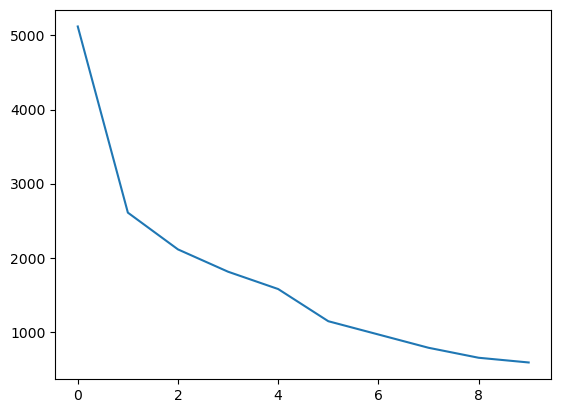

In [4]:
plt.plot(eigval[:10])